## prompt
以下の手順で`data_persons.csv`を作成してください。
1. `data_persons.csv`の1行目を以下にする。
`person_id,household_id,person_role_in_household,誕生年月日,収入,性別`
2. persons.json を読み込み、`persons_list`とする。
3. `persons_list`を順に以下処理を行う。`household_id`が`null`の場合はスキップ
4. 一意な`person_id`を付与する。
5. `person_role_in_household`について、`age`が18以上の場合は"親", 18未満の場合は"子"とする
6. `誕生年月日`は"YYYY-01-01"とし、"YYYY"は{2025 - age}で計算した値とする。
7. `収入`は`income * 10000`で計算された値とする。
8. `性別`は`sex`が"male"の場合は"男性", "female"の場合は"女性"とする。
9. 設定した値を`data_persons.csv`に追加する。



In [49]:
import json, csv, sys
from pathlib import Path
from datetime import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from openfisca_core.simulation_builder import SimulationBuilder
from openfisca_japan import CountryTaxBenefitSystem

# 日本語フォントの設定（macOS用）
plt.rcParams['font.family'] = 'Hiragino Sans'

In [ ]:


root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero')
json_path = root / 'persons.json'
csv_path = root / 'data_persons.csv'

# 読み込み
with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# persons_list の決定（配列/辞書どちらにも対応）
persons_list = []
if isinstance(data, list):
    persons_list = data
elif isinstance(data, dict):
    if isinstance(data.get('persons'), list):
        persons_list = data['persons']
    else:
        values = list(data.values())
        if values and all(isinstance(v, dict) for v in values):
            persons_list = values
        else:
            persons_list = []

# CSV 書き込み
header = ['person_id','household_id','person_role_in_household','誕生年月日','収入','性別']
with open(csv_path, 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    person_id_seq = 1
    for p in persons_list:
        if not isinstance(p, dict):
            continue
        household_id = p.get('household_id')
        if household_id is None:
            continue
        # age
        age = p.get('age')
        try:
            age_int = int(age) if age is not None else None
        except Exception:
            age_int = None
        # role
        if age_int is None:
            role = ''
        else:
            role = '親' if age_int >= 18 else '子'
        # 誕生年月日
        if age_int is None:
            dob = ''
        else:
            year = 2025 - age_int
            dob = f"{year:04d}-01-01"
        # 収入
        income = p.get('income')
        try:
            income_val = float(income) if income is not None else 0.0
        except Exception:
            income_val = 0.0
        income_out = int(round(income_val * 10000))
        # 性別
        sex = (p.get('sex') or '').lower()
        if sex == 'male':
            gender = '男性'
        elif sex == 'female':
            gender = '女性'
        else:
            gender = ''
        # 行追加
        writer.writerow([person_id_seq, household_id, role, dob, income_out, gender])
        person_id_seq += 1

print(str(csv_path))

## prompt
以下の手順で`data_households.csv`を作成するコードをnotebookに記載してください。
1. `data_households.csv`の1行目を以下にする。
`household_id,居住都道府県,居住市区町村`
2. persons.json を読み込み、`persons_list`とする。
3. `persons_list`の`household_id`の最小値と最大値を取得する。
4. 最小値から最大値までの`household_id`を`data_households.csv`に追加する。`居住都道府県`は"神奈川県", `居住市区町村`は"横浜市"とする。
5. 設定した値を`data_persons.csv`に追加する。



In [2]:
# data_households.csv を生成する
root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero')
json_path = root / 'persons.json'
hh_csv_path = root / 'data_households.csv'

# persons.json 読み込み
with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# persons_list の抽出（配列/辞書に対応）
if isinstance(data, list):
    persons_list = data
elif isinstance(data, dict):
    if isinstance(data.get('persons'), list):
        persons_list = data['persons']
    else:
        vals = list(data.values())
        if vals and all(isinstance(v, dict) for v in vals):
            persons_list = vals
        else:
            persons_list = []
else:
    persons_list = []

# household_id 値の収集（null/None を除外）
household_ids = []
for p in persons_list:
    if not isinstance(p, dict):
        continue
    hid = p.get('household_id')
    if hid is None:
        continue
    try:
        household_ids.append(int(hid))
    except Exception:
        continue

if household_ids:
    hh_min, hh_max = min(household_ids), max(household_ids)
else:
    hh_min = hh_max = None

# CSV 書き込み
header = ['household_id', '居住都道府県', '居住市区町村']
with open(hh_csv_path, 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    if hh_min is not None and hh_max is not None:
        for hid in range(hh_min, hh_max + 1):
            writer.writerow([hid, '神奈川県', '横浜市'])

print(f'Wrote: {hh_csv_path}')


Wrote: /Users/naoya/develop/proj-inclusive/OpenFisca-Zero/data_households.csv


In [ ]:
# persons_BI.json を生成する
from pathlib import Path
import csv, json

root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero')
persons_csv = root / 'data_persons.csv'
households_csv_primary = root / 'data_households.csv'
households_csv_fallback = root / 'data_households_BI.csv'
output_json = root / 'persons_BI.json'

# 必要カラム
need_cols = ['生活保護', '児童手当', '児童育成手当', '児童扶養手当_最小']

# householdsの読み込み（必要列がなければフォールバックを試す）
def load_households_bi_map():
    def read_csv(path: Path):
        if not path.exists():
            return None, None
        with path.open('r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            fieldnames = reader.fieldnames or []
            rows = list(reader)
        return fieldnames, rows

    # primary
    fn, rows = read_csv(households_csv_primary)
    source = households_csv_primary
    if not fn or any(col not in fn for col in need_cols):
        # fallback
        fn_fb, rows_fb = read_csv(households_csv_fallback)
        if fn_fb and all(col in fn_fb for col in need_cols):
            fn, rows, source = fn_fb, rows_fb, households_csv_fallback
        else:
            fn, rows, source = fn, rows, households_csv_primary  # どちらも揃わない場合はprimaryのまま

    hh_map = {}
    if rows:
        for r in rows:
            hid = str(r.get('household_id')) if r.get('household_id') is not None else None
            if not hid or hid == 'None':
                continue
            # 数値変換（欠損は0）
            def to_int(x):
                try:
                    return int(float(str(x)))
                except Exception:
                    return 0
            vals = {c: to_int(r.get(c)) for c in need_cols}
            hh_map[hid] = vals
    return hh_map, source

households_bi_map, households_source = load_households_bi_map()

# personsの読み込み
with persons_csv.open('r', encoding='utf-8') as f:
    persons_reader = csv.DictReader(f)
    persons_rows = list(persons_reader)

# household_idごとに1回だけ最低生活保障を算入
seen_households = set()

# 出力: person_id -> dict で出力（指示1に合わせる）
persons_bi = {}
for row in persons_rows:
    person_id = str(row.get('person_id'))
    if not person_id or person_id == 'None':
        continue

    household_id = str(row.get('household_id')) if row.get('household_id') is not None else ''

    entry = {
        'household_id': household_id,
        'person_role_in_household': row.get('person_role_in_household', ''),
        '誕生年月日': row.get('誕生年月日', ''),
        '性別': row.get('性別', ''),
        '収入': row.get('収入', ''),
    }

    # 最低生活保障の計算
    min_life_support = 0
    if household_id:
        if household_id not in seen_households:
            bi_vals = households_bi_map.get(household_id, {}) if households_bi_map else {}
            min_life_support = sum(int(bi_vals.get(k, 0)) for k in need_cols)
            seen_households.add(household_id)
        else:
            min_life_support = 0
    entry['最低生活保障'] = min_life_support

    persons_bi[person_id] = entry

# JSON出力（インデント付き）
with output_json.open('w', encoding='utf-8') as f:
    json.dump(persons_bi, f, ensure_ascii=False, indent=2)

print(f'Wrote: {output_json}')


In [13]:
# OpenFisca-Japanで最低生活費を計算する

## データの読み込み ###
# 人物単位で定義される属性(ex. 誕生年月日)と世帯単位で定義される属性(ex. 居住都道府県)を区別して読み込む
# 人物ID, 世帯IDとそれぞれ紐づくため

# 人物データ. 
data_persons = np.loadtxt("data_persons.csv", delimiter=",", dtype=str,
                            encoding="utf-8")
# data_persons_dict = {列名: 列の配列} のフォーマットにする
data_persons_dict = {}
for i in range(len(data_persons[0])):
    data_persons_dict[data_persons[0, i]] = data_persons[1:, i]

# 世帯データ
data_households = np.loadtxt("data_households.csv", delimiter=",", dtype=str,
                                encoding="utf-8")
# data_households_dict = {列名: 列の配列} のフォーマットにする
data_households_dict = {}
for i in range(len(data_households[0])):
    data_households_dict[data_households[0, i]] = data_households[1:, i]


### OpenFiscaの準備 ###
tax_benefit_system = CountryTaxBenefitSystem()
sb = SimulationBuilder()
sb.create_entities(tax_benefit_system)

# 人物(世帯員)と世帯のそれぞれ一意なIDの登録
sb.declare_person_entity("人物", data_persons_dict["person_id"])
household_instance = sb.declare_entity("世帯", data_households_dict["household_id"])

# 人物(世帯員)と世帯の紐付け #
person_household = data_persons_dict["household_id"]
# 人物(世帯員, entity)のrole. ["親", "子", "祖父母"] のいずれか
person_household_role = data_persons_dict["person_role_in_household"]
sb.join_with_persons(household_instance, person_household, person_household_role)



# 制度計算の対象とする日時. YYYY-MM-DD 形式で記述する. 過去の日時も指定可能
period = "2025-11-01"  # 12月は期末一時扶助が入るためそれ以外


### 必須の入力属性 ###
# (その他の必須ではない属性は未入力の場合デフォルト値が適用されるため、基本的な制度の計算には影響なし.
# ex. 身体障害者手帳: 無)
simulation = sb.build(tax_benefit_system)

# 人物の年齢は誕生年月日とperiodによって算出される.
# 年齢のみを指定すると子供の学年が定義されないため、誕生年月日の指定が必要
# YYYY-MM-DD 形式
simulation.set_input("誕生年月日", period, data_persons_dict["誕生年月日"])
simulation.set_input("性別", period, data_persons_dict["性別"])
# 数値の文字列はint型に変換
# 収入に依存しない最低生活費を算出するため収入は0円とする
simulation.set_input("収入", period, np.zeros(len(data_persons_dict["収入"]), dtype=float))
simulation.set_input("居住都道府県", period, data_households_dict["居住都道府県"])
simulation.set_input("居住市区町村", period, data_households_dict["居住市区町村"])

allowance_list = [
    "生活保護",
    "児童手当",  # 各種手当
    "児童育成手当",  # 各種手当
    "児童扶養手当_最小"  # 各種手当
]

# NOTE: 生活保護 = np.clip(最低生活費 - 月収 - 各種手当額, 0.0, None) で計算されるため
# 最低生活費 = 生活保護 (+ 月収; 0) + 各種手当額 とすると、
# OpenFiscaの最低生活費が各種手当額より小さい場合は0にclipされ、
# 結果的に最低生活費は各種手当額になる。（児童関連の手当なので含めて良い）

### シミュレーション実行 ###
# (中間変数を出力することも可能. ex. 世帯高所得)
for allowance in allowance_list:
    amount = simulation.calculate(allowance, period)
    data_households_dict[allowance] = amount


# 例: data_persons_dict = {"person_id": np.array([...]), "household_id": np.array([...]), ...}
df = pd.DataFrame({k: np.asarray(v) for k, v in data_households_dict.items()})
df.to_csv("data_households_BI.csv", index=False, encoding="utf-8")


In [7]:
data_persons_dict["性別"]

array(['男性', '男性', '男性', ..., '女性', '女性', '女性'], dtype='<U24')

In [12]:
for k, v in data_persons_dict.items():
    print(k, len(v))

person_id 9244
household_id 9244
person_role_in_household 9244
誕生年月日 9244
収入 9244
性別 9244
生活保護 4641
児童手当 4641
児童育成手当 4641
児童扶養手当_最小 4641


## 個人単位の算出式

最低生活保障 + cb(収入)^a
- 最低生活保障は世帯で1人が最低生活費を受け取る

## prompt
以下の手順で`data_persons.csv`, `data_households.csv`をもとに`persons_BI.json`を作成するコードをnotebookに記載してください。
1. `persons_BI.json`のkeyは`person_id`(str型)とする。
2. `person_id`のvalueは以下のkey, valueからなるdictとする。
    - `household_id`: `data_persons.csv`の`household_id`行の値
    - `person_role_in_household`: `data_persons.csv`の`person_role_in_household`行の値
    - `誕生年月日`: `data_persons.csv`の`誕生年月日`行の値
    - `性別`: `data_persons.csv`の`性別`行の値
    - `収入`: `data_persons.csv`の`収入`行の値
3. **上記`household_id`が既に参照済みのものでない場合**、の"生活保護", "児童手当", "児童育成手当", "児童扶養手当_最小"の値を`data_households.csv`から取得し、以下の処理を行う。`最低生活保障 = 生活保護 + 児童手当 + 児童育成手当 + 児童扶養手当_最小`を算出し、上記dictに`最低生活保障`の値を追加する。`household_id`が既に参照済みの場合、`最低生活保障`は0としてdictに追加する。つまり、同一の`household_id`をもつpersonに対して、1人のみ最低生活保障を算出する。
4. 上記のdictのlistを`persons_BI.json`として出力する。

In [14]:
# persons_BI.json を生成する

root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero')
persons_csv = root / 'data_persons.csv'
households_csv_primary = root / 'data_households.csv'
households_csv_fallback = root / 'data_households_BI.csv'
output_json = root / 'persons_BI.json'

# 必要カラム
need_cols = ['生活保護', '児童手当', '児童育成手当', '児童扶養手当_最小']

# householdsの読み込み（必要列がなければフォールバックを試す）
def load_households_bi_map():
    def read_csv(path: Path):
        if not path.exists():
            return None, None
        with path.open('r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            fieldnames = reader.fieldnames or []
            rows = list(reader)
        return fieldnames, rows

    # primary
    fn, rows = read_csv(households_csv_primary)
    source = households_csv_primary
    if not fn or any(col not in fn for col in need_cols):
        # fallback
        fn_fb, rows_fb = read_csv(households_csv_fallback)
        if fn_fb and all(col in fn_fb for col in need_cols):
            fn, rows, source = fn_fb, rows_fb, households_csv_fallback
        else:
            fn, rows, source = fn, rows, households_csv_primary  # どちらも揃わない場合はprimaryのまま

    hh_map = {}
    if rows:
        for r in rows:
            hid = str(r.get('household_id')) if r.get('household_id') is not None else None
            if not hid or hid == 'None':
                continue
            # 数値変換（欠損は0）
            def to_int(x):
                try:
                    return int(float(str(x)))
                except Exception:
                    return 0
            vals = {c: to_int(r.get(c)) for c in need_cols}
            hh_map[hid] = vals
    return hh_map, source

households_bi_map, households_source = load_households_bi_map()

# personsの読み込み
with persons_csv.open('r', encoding='utf-8') as f:
    persons_reader = csv.DictReader(f)
    persons_rows = list(persons_reader)

# household_idごとに1回だけ最低生活保障を算入
seen_households = set()

# 出力: person_id -> dict で出力（指示1に合わせる）
persons_bi = {}
for row in persons_rows:
    person_id = str(row.get('person_id'))
    if not person_id or person_id == 'None':
        continue

    household_id = str(row.get('household_id')) if row.get('household_id') is not None else ''

    entry = {
        'household_id': household_id,
        'person_role_in_household': row.get('person_role_in_household', ''),
        '誕生年月日': row.get('誕生年月日', ''),
        '性別': row.get('性別', ''),
        '収入': row.get('収入', ''),
    }

    # 最低生活保障の計算
    min_life_support = 0
    if household_id:
        if household_id not in seen_households:
            bi_vals = households_bi_map.get(household_id, {}) if households_bi_map else {}
            min_life_support = sum(int(bi_vals.get(k, 0)) for k in need_cols)
            seen_households.add(household_id)
        else:
            min_life_support = 0
    entry['最低生活保障'] = min_life_support

    persons_bi[person_id] = entry

# JSON出力（インデント付き）
with output_json.open('w', encoding='utf-8') as f:
    json.dump(persons_bi, f, ensure_ascii=False, indent=2)

print(f'Wrote: {output_json}')

Wrote: /Users/naoya/develop/proj-inclusive/OpenFisca-Zero/persons_BI.json


## prompt
以下の手順で`persons_BI.json`をもとに`persons_BI_income.json`を作成するコードをnotebookに記載してください。
1. `persons_BI.json`の各key(person_id)ごとに以下の処理を行う。
2. key`person_role_in_household`が`親`の場合、key`収入`の値をkey`収入_親`の値として追加する。
3. key`person_role_in_household`が`子`の場合、まず同じ`household_id`のpersonのdictを収集する。その中で、key`person_role_in_household`が`親`のpersonの`収入`を平均し、もとの`子`のkey`収入_親`の値として追加する。
4. 上記のdictのlistを`persons_BI_income.json`として出力する。

In [19]:
# persons_BI.json を基に persons_BI_income.json を生成する
root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero')
input_json = root / 'persons_BI.json'
output_json = root / 'persons_BI_income.json'

# 入力読込（persons_BI.json は person_id -> dict の形）
with input_json.open('r', encoding='utf-8') as f:
    persons_bi = json.load(f)

# household_id ごとの親の収入リストを構築
household_to_parent_incomes = {}

def to_number(x):
    try:
        return float(x)
    except Exception:
        return 0.0

for person_id, info in persons_bi.items():
    role = info.get('person_role_in_household')
    hid = str(info.get('household_id') or '')
    if not hid:
        continue
    if role == '親':
        income_val = to_number(info.get('収入', 0))
        household_to_parent_incomes.setdefault(hid, []).append(income_val)

# 出力: list[dict] として person_id も含めて出力
result_list = []
for person_id, info in persons_bi.items():
    role = info.get('person_role_in_household')
    hid = str(info.get('household_id') or '')

    # 収入_親の算出
    if role == '親':
        parent_income = to_number(info.get('収入', 0))
    else:  # 子
        parent_incomes = household_to_parent_incomes.get(hid, [])
        if parent_incomes:
            parent_income = sum(parent_incomes) / len(parent_incomes)
        else:
            parent_income = 0.0

    # 元の情報に person_id と 収入_親 を付与
    out = dict(info)
    out['person_id'] = str(person_id)
    out['収入_親'] = parent_income
    result_list.append(out)

with output_json.open('w', encoding='utf-8') as f:
    json.dump(result_list, f, ensure_ascii=False, indent=2)

print(f'Wrote: {output_json}')

Wrote: /Users/naoya/develop/proj-inclusive/OpenFisca-Zero/persons_BI_income.json


In [20]:
# persons_BI_income.json を person_id: dict の形に変換し、各dictのperson_idを除去
root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero')
input_json = root / 'persons_BI_income.json'
output_json = root / 'persons_BI_income.json'  # 上書き

# 入力読込（list形式）
with input_json.open('r', encoding='utf-8') as f:
    persons_list = json.load(f)

# person_id: dict の形に変換し、各dictのperson_idを除去
persons_dict = {}
for person in persons_list:
    person_id = str(person.get('person_id', ''))
    if not person_id:
        continue
    # person_idをコピーして除去
    person_copy = dict(person)
    person_copy.pop('person_id', None)
    persons_dict[person_id] = person_copy

# 上書き保存
with output_json.open('w', encoding='utf-8') as f:
    json.dump(persons_dict, f, ensure_ascii=False, indent=2)

print(f'Converted: {len(persons_list)} items -> {len(persons_dict)} keys')
print(f'Saved: {output_json}')



Converted: 9244 items -> 9244 keys
Saved: /Users/naoya/develop/proj-inclusive/OpenFisca-Zero/persons_BI_income.json


In [21]:
with input_json.open('r', encoding='utf-8') as f:
    persons_dict = json.load(f)

for person_id, person in persons_dict.items():
    person["収入"] = float(person["収入"])
    age = person["誕生年月日"]
    if age:
        year = int(age[:4])
        person["年齢"] = 2025 - year
    else:
        person["年齢"] = None

with output_json.open('w', encoding='utf-8') as f:
    json.dump(persons_dict, f, ensure_ascii=False, indent=2)

print(f'Wrote: {output_json}')


Wrote: /Users/naoya/develop/proj-inclusive/OpenFisca-Zero/persons_BI_income.json


In [ ]:
# calc sume of income and BI
persons_bi_income = json.load(open(root / 'persons_BI_income.json', 'r', encoding='utf-8'))

income_actual_list = []
bi_list = []
for person_id, person in persons_bi_income.items():
    income_actual_list.append(person["収入"])
    bi_list.append(person["最低生活保障"] * 12)  # 月額を年額に変換

income_actual_total = sum(income_actual_list)
bi_total = sum(bi_list)

print(f"実収入合計: {income_actual_total / 10000}万円")
print(f"最低生活保障合計(年額): {bi_total / 10000}万円")
print(f"実収入合計 - 最低生活保障合計: {(income_actual_total - bi_total) / 10000}万円")


実収入合計: 3264385.33万円
最低生活保障合計(年額): 1007856.5856万円
実収入合計 - 最低生活保障合計: 2256528.7444万円


## prompt 余剰金額の計算
以下の手順で余剰金額`surplus`を計算し、`income_actual_total`, `bi_total`と比較するコードをnotebookに記載してください。
1. `persons_bi_income`の各personごとに以下の処理を行う
2. `収入_親`と`年齢`を取得する。
3. 同じ世帯(`household_id`)のpersonを収集し、以下のパターンに分類し、世帯補正パラメータ`beta`を選択
   1. 自分が18歳未満: "child"
   2. 自分のみの単身世帯で、年齢が65歳未満: "single_young"
   3. 自分のみの単身世帯で、年齢が65歳以上: "single_elder"
   4. 夫婦(世帯員が18歳以上の2人のみ)の世帯で、片方が年齢が65歳未満: "couple_young"
   5. 夫婦(世帯員が18歳以上の2人のみ)の世帯で、両方が年齢が65歳以上: "couple_elder"
4. 累進課税収入`deduct_income`を`alpha_offset * (収入_親 / alpha_offset) ** alpha`で計算する。
5. `deduct_income`に世帯補正パラメータ`beta`を適用し`beta_deduct_income`とする。
6. `beta_deduct_income`に`gamma`を乗算し`surplus`とする。
7. 全てのpersonの`surplus`を合計し、余剰金額`surplus_total`とする。
8. `income_actual_total`と、`bi_total + surplus_total`を比較する



In [34]:
# 余剰金額 surplus を計算し、income_actual_total, bi_total と比較
root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero')
persons_bi_income_json = root / 'persons_BI_income.json'
persons_bi_income_household_json = root / 'persons_BI_income_household.json'

# パラメータ定義（必要に応じて調整）
alpha_offset = 1_000_000  # 例: 100万円
alpha = 0.8  # 例: 0.5
gamma = 1.0  # 例: 1.0

# 世帯補正パラメータ beta（パターンごと）
beta_values = {
    "single_young": 1, 
    "single_elder": 0.75,  # 高齢で消費減   
    "couple_young": 0.75,  # 共用でコスト減
    "couple_elder": 0.5,  # 高齢, 共用で消費減
    "child": 0.5  # 子供, 共用で消費減
}

# persons_BI_income.json を読み込み
with persons_bi_income_json.open('r', encoding='utf-8') as f:
    persons_bi_income = json.load(f)

# 年齢計算用のヘルパー関数
def calculate_age(birth_date_str):
    """誕生年月日から年齢を計算（YYYY-01-01形式）"""
    if not birth_date_str:
        return None
    try:
        year = int(birth_date_str[:4])
        return 2025 - year
    except Exception:
        return None

# 世帯ごとのpersonをグループ化
household_to_persons = defaultdict(list)
for person_id, person in persons_bi_income.items():
    household_id = str(person.get('household_id', ''))
    if household_id:
        household_to_persons[household_id].append((person_id, person))

# 各personのsurplusを計算
surplus_total = 0.0
for person_id, person in persons_bi_income.items():
    # 収入_親と年齢を取得
    parent_income = float(person.get('収入_親', 0))
    age = person.get('年齢')  # 自分の年齢
    if age is None:
        birth_date = person.get('誕生年月日', '')
        age = calculate_age(birth_date)
    
    household_id = str(person.get('household_id', ''))
    if not household_id:
        continue
    
    # 同じ世帯のpersonを収集
    household_persons = household_to_persons.get(household_id, [])
    
    # パターン分類とbeta選択
    beta = 1.0  # デフォルト値
    if age is not None and age < 18:  # 自分が児童. 児童のみの単身世帯はない
        household_type = "child"
        beta = beta_values[household_type]
        person["世帯タイプ"] = household_type
    else:
        # 世帯員(児童含む)をカウント
        members = [p for _, p in household_persons]
        if len(members) == 1:  # 単身世帯            
            if age is not None and age < 65:
                household_type = "single_young"
                beta = beta_values[household_type]
                person["世帯タイプ"] = household_type
            else:
                household_type = "single_elder"
                beta = beta_values[household_type]
                person["世帯タイプ"] = household_type
        else:  # 複数人世帯(児童含む)
            ages = [p.get('年齢') for p in members if p.get('年齢') is not None]
            if any(a < 65 for a in ages):  # 1人でも65歳未満
                household_type = "couple_young"
                beta = beta_values[household_type]
                person["世帯タイプ"] = household_type
            else:
                household_type = "couple_elder"
                beta = beta_values[household_type]
                person["世帯タイプ"] = household_type
    
    # 累進課税収入の計算
    if alpha_offset > 0 and parent_income > 0:
        deduct_income = alpha_offset * ((parent_income / alpha_offset) ** alpha)
    else:
        deduct_income = 0.0
    
    # beta適用
    beta_deduct_income = deduct_income * beta
    
    # gamma適用してsurplus計算
    surplus = beta_deduct_income * gamma
    surplus_total += surplus

# persons_bi_incomeを出力
with persons_bi_income_household_json.open('w', encoding='utf-8') as f:
    json.dump(persons_bi_income, f, ensure_ascii=False, indent=2)

# income_actual_total と bi_total を計算（既存のセルから取得するか、再計算）
income_actual_list = []
bi_list = []
for person_id, person in persons_bi_income.items():
    income_actual_list.append(float(person.get('収入', 0)))
    bi_list.append(float(person.get('最低生活保障', 0)) * 12)  # 月額を年額に変換

income_actual_total = sum(income_actual_list)
bi_total = sum(bi_list)

# 比較結果を表示
print(f"実収入合計: {income_actual_total / 100_000_000:.2f}億円")
print(f"最低生活保障合計(年額): {bi_total / 100_000_000:.2f}億円")
print(f"余剰金額合計: {surplus_total / 100_000_000:.2f}億円")
print(f"\n比較:")
print(f"income_actual_total: {income_actual_total / 100_000_000:.2f}億円")
print(f"bi_total + surplus_total: {(bi_total + surplus_total) / 100_000_000:.2f}億円")
print(f"差額: {(income_actual_total - (bi_total + surplus_total)) / 100_000_000:.2f}億円")


実収入合計: 326.44億円
最低生活保障合計(年額): 100.79億円
余剰金額合計: 196.23億円

比較:
income_actual_total: 326.44億円
bi_total + surplus_total: 297.02億円
差額: 29.42億円


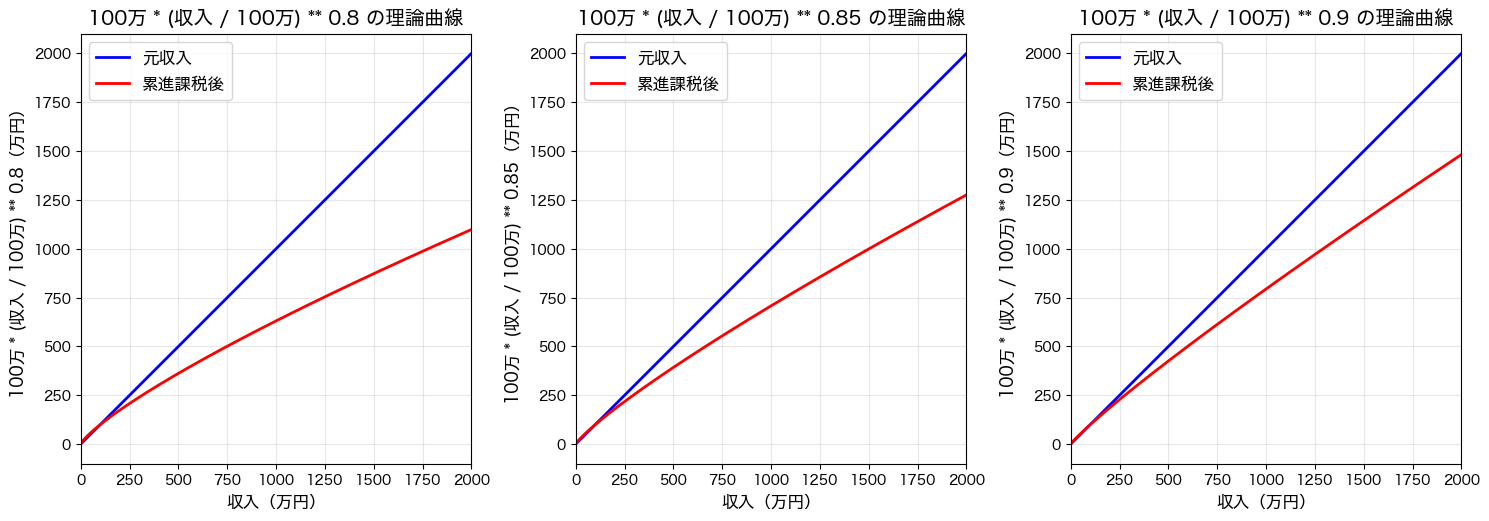

In [43]:
# 0~2000万円の範囲で連続的に 100万 * (値 / 100万) ** 0.8 を計算してプロット

# 0~2000万円の範囲で連続的な値を生成
x = np.linspace(0, 2000, 1000)  # 0から2000万円まで1000点

### 逓減率0.8の累進課税 ###
# 100万 * (値 / 100万) ** 0.8 を計算（万円単位）
# xが0の場合は0を返す
y = np.where(x > 0, 100 * ((x / 100) ** 0.8), 0)

# グラフを描画
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.plot(x, x, linewidth=2, color='blue', label='元収入')
plt.plot(x, y, linewidth=2, color='red', label="累進課税後")
plt.xlabel('収入（万円）', fontsize=12)
plt.ylabel('100万 * (収入 / 100万) ** 0.8（万円）', fontsize=12)
plt.title('100万 * (収入 / 100万) ** 0.8 の理論曲線', fontsize=14)
plt.xlim(0, 2000)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
# x, yのアスペクトを1:1にする
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

### 逓減率0.85の累進課税 ###
# 100万 * (値 / 100万) ** 0.85 を計算（万円単位）
# xが0の場合は0を返す
y085 = np.where(x > 0, 100 * ((x / 100) ** 0.85), 0)
# グラフを描画
plt.subplot(1, 3, 2)
plt.plot(x, x, linewidth=2, color='blue', label='元収入')
plt.plot(x, y085, linewidth=2, color='red', label="累進課税後")
plt.xlabel('収入（万円）', fontsize=12)
plt.ylabel('100万 * (収入 / 100万) ** 0.85（万円）', fontsize=12)
plt.title('100万 * (収入 / 100万) ** 0.85 の理論曲線', fontsize=14)
plt.xlim(0, 2000)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
# x, yのアスペクトを1:1にする
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

# 逓減率0.9の累進課税
# 100万 * (値 / 100万) ** 0.9 を計算（万円単位）
# xが0の場合は0を返す
y09 = np.where(x > 0, 100 * ((x / 100) ** 0.9), 0)
# グラフを描画
plt.subplot(1, 3, 3)
plt.plot(x, x, linewidth=2, color='blue', label='元収入')
plt.plot(x, y09, linewidth=2, color='red', label="累進課税後")
plt.xlabel('収入（万円）', fontsize=12)
plt.ylabel('100万 * (収入 / 100万) ** 0.9（万円）', fontsize=12)
plt.title('100万 * (収入 / 100万) ** 0.9 の理論曲線', fontsize=14)
plt.xlim(0, 2000)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
# x, yのアスペクトを1:1にする
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

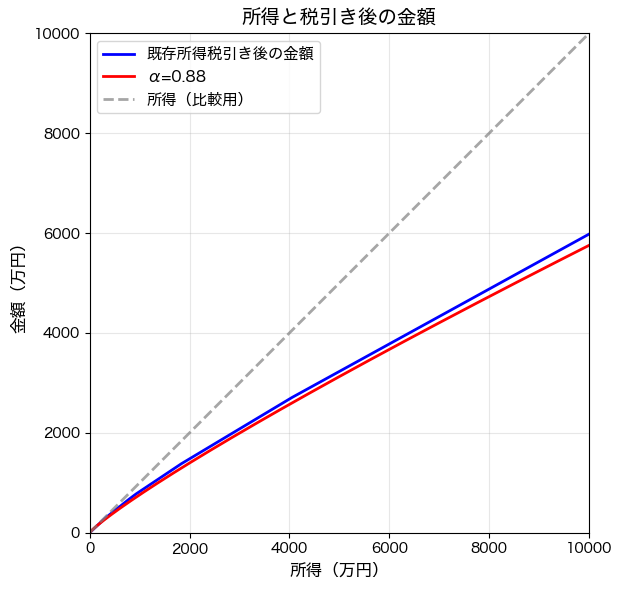

計算範囲: 0円 ~ 1億円
計算点数: 10000


In [58]:
# income_tax_listに基づいて所得税引き後の金額をグラフ化. 累進課税率のグラフ
income_tax_list = [
    {
        "income_range": (1000, 1_949_000),  
        "tax_rate": 0.05,
        "deduction": 0,
    },
    {
        "income_range": (1_950_000, 3_299_000),
        "tax_rate": 0.1,
        "deduction": 97_500,
    },
    {
        "income_range": (3_300_000, 6_949_000),
        "tax_rate": 0.2,
        "deduction": 427_500,
    },
    {   
        "income_range": (6_950_000, 8_999_000),
        "tax_rate": 0.23,
        "deduction": 636_000,
    },
    {
        "income_range": (9_000_000, 17_999_000),
        "tax_rate": 0.33,
        "deduction": 1_536_000,
    },
    {
        "income_range": (18_000_000, 39_999_000),
        "tax_rate": 0.4,
        "deduction": 2_796_000,
    },
    {
        "income_range": (40_000_000, float('inf')),
        "tax_rate": 0.45,
        "deduction": 4_796_000,
    },
]

# 横軸: 0円から1億円まで
income_range = np.linspace(0, 100_000_000, 10000)  # 1億円まで10000点

# 所得税引き後の金額を計算する関数
def calculate_after_tax_income(income):
    """所得から所得税を引いた金額を計算"""
    for tax_info in income_tax_list:
        min_income, max_income = tax_info['income_range']
        if min_income <= income <= max_income:
            tax = income * tax_info['tax_rate'] - tax_info['deduction']
            # 所得税が負の値にならないようにする
            tax = max(0, tax)
            return income - tax
    # 範囲外の場合は所得税なし
    return income

# 各所得に対する所得税引き後の金額を計算
after_tax_incomes = [calculate_after_tax_income(inc) for inc in income_range]

# グラフを描画
plt.figure(figsize=(9, 6))
plt.plot(income_range, after_tax_incomes, label='既存所得税引き後の金額', linewidth=2, color='blue')

# 逓減率0.9の累進課税
# 100万 * (値 / 100万) ** 0.9 を計算（万円単位）
# xが0の場合は0を返す
alpha = 0.88
y09 = np.where(income_range / 1_000_000 > 0, 
                1_000_000 * ((income_range / 1_000_000) ** alpha), 0)
plt.plot(income_range, y09, linewidth=2, color='red', label=f"α={alpha}")

plt.plot(income_range, income_range, label='所得（比較用）', linewidth=2, linestyle='--', color='gray', alpha=0.7)

# 横軸と縦軸を万円単位で表示


def format_manen(x, pos):
    """万円単位に変換して表示"""
    return f'{x/10000:.0f}'

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_manen))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_manen))
# x, yのアスペクトを1:1にする
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('所得（万円）', fontsize=12)
plt.ylabel('金額（万円）', fontsize=12)
plt.title('所得と税引き後の金額', fontsize=14)
plt.xlim(0, 100_000_000)
plt.ylim(0, 100_000_000)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"計算範囲: 0円 ~ 1億円")
print(f"計算点数: {len(income_range)}")


In [36]:
# 余剰金額 surplus を計算し、income_actual_total, bi_total と比較
root = Path('/Users/naoya/develop/proj-inclusive/OpenFisca-Zero')
persons_bi_income_json = root / 'persons_BI_income.json'
persons_bi_income_household_json = root / 'persons_BI_income_household.json'

# persons_BI_income.json を読み込み
with persons_bi_income_json.open('r', encoding='utf-8') as f:
    persons_bi_income = json.load(f)

# 年齢計算用のヘルパー関数
def calculate_age(birth_date_str):
    """誕生年月日から年齢を計算（YYYY-01-01形式）"""
    if not birth_date_str:
        return None
    try:
        year = int(birth_date_str[:4])
        return 2025 - year
    except Exception:
        return None

def calculate_surplus(persons_bi_income_household, 
                        alpha_offset, alpha, gamma, beta_values):
    # 各personのsurplusを計算
    surplus_total = 0.0
    for person_id, person in persons_bi_income_household.items():
        # 収入_親と年齢を取得
        parent_income = float(person.get('収入_親', 0))
        age = person.get('年齢')  # 自分の年齢
        if age is None:
            birth_date = person.get('誕生年月日', '')
            age = calculate_age(birth_date)
        
        household_id = str(person.get('household_id', ''))
        if not household_id:
            continue

        household_type = person.get('世帯タイプ', None)
        beta = beta_values[household_type]
        
        # 累進課税収入の計算
        if alpha_offset > 0 and parent_income > 0:
            deduct_income = alpha_offset * ((parent_income / alpha_offset) ** alpha)
        else:
            deduct_income = 0.0
        
        # beta適用
        beta_deduct_income = deduct_income * beta
        
        # gamma適用してsurplus計算
        surplus = beta_deduct_income * gamma
        surplus_total += surplus


    # income_actual_total と bi_total を計算（既存のセルから取得するか、再計算）
    income_actual_list = []
    bi_list = []
    for person_id, person in persons_bi_income_household.items():
        income_actual_list.append(float(person.get('収入', 0)))
        bi_list.append(float(person.get('最低生活保障', 0)) * 12)  # 月額を年額に変換

    income_actual_total = sum(income_actual_list)
    bi_total = sum(bi_list)

    # 比較結果を表示
    print(f"実収入合計: {income_actual_total / 100_000_000:.2f}億円")
    print(f"最低生活保障合計(年額): {bi_total / 100_000_000:.2f}億円")
    print(f"余剰金額合計: {surplus_total / 100_000_000:.2f}億円")
    print(f"\n比較:")
    print(f"income_actual_total: {income_actual_total / 100_000_000:.2f}億円")
    print(f"bi_total + surplus_total: {(bi_total + surplus_total) / 100_000_000:.2f}億円")
    print(f"差額: {(income_actual_total - (bi_total + surplus_total)) / 100_000_000:.2f}億円")


In [37]:
persons_bi_income_household_json = root / 'persons_BI_income_household.json'
with persons_bi_income_household_json.open('r', encoding='utf-8') as f:
    persons_bi_income_household = json.load(f)

# パラメータ定義（必要に応じて調整）
alpha_offset = 1_000_000  # 例: 100万円
alpha = 0.8  # 例: 0.5
gamma = 1.0  # 例: 1.0

# 世帯補正パラメータ beta（パターンごと）
beta_values = {
    "single_young": 1, 
    "single_elder": 0.75,  # 高齢で消費減   
    "couple_young": 0.75,  # 共用でコスト減
    "couple_elder": 0.5,  # 高齢, 共用で消費減
    "child": 0.5  # 子供, 共用で消費減
}

calculate_surplus(persons_bi_income_household, alpha_offset, alpha, gamma, beta_values)


実収入合計: 326.44億円
最低生活保障合計(年額): 100.79億円
余剰金額合計: 196.23億円

比較:
income_actual_total: 326.44億円
bi_total + surplus_total: 297.02億円
差額: 29.42億円


In [38]:
persons_bi_income_household_json = root / 'persons_BI_income_household.json'
with persons_bi_income_household_json.open('r', encoding='utf-8') as f:
    persons_bi_income_household = json.load(f)

# パラメータ定義（必要に応じて調整）
alpha_offset = 1_000_000  # 例: 100万円
alpha = 0.8  # 例: 0.5
gamma = 1.0  # 例: 1.0

# 世帯補正パラメータ beta（パターンごと）
beta_values = {
    "single_young": 1, 
    "single_elder": 0.75,  # 高齢で消費減   
    "couple_young": 0.75,  # 共用でコスト減
    "couple_elder": 0.5,  # 高齢, 共用で消費減
    "child": 0.6  # 子供, 共用で消費減
}

calculate_surplus(persons_bi_income_household, alpha_offset, alpha, gamma, beta_values)


実収入合計: 326.44億円
最低生活保障合計(年額): 100.79億円
余剰金額合計: 200.09億円

比較:
income_actual_total: 326.44億円
bi_total + surplus_total: 300.88億円
差額: 25.56億円


In [42]:
persons_bi_income_household_json = root / 'persons_BI_income_household.json'
with persons_bi_income_household_json.open('r', encoding='utf-8') as f:
    persons_bi_income_household = json.load(f)

# パラメータ定義（必要に応じて調整）
alpha_offset = 1_000_000  # 例: 100万円
alpha = 0.85  # 例: 0.5
gamma = 1.0  # 例: 1.0

# 世帯補正パラメータ beta（パターンごと）
beta_values = {
    "single_young": 1, 
    "single_elder": 0.75,  # 高齢で消費減   
    "couple_young": 0.75,  # 共用でコスト減
    "couple_elder": 0.5,  # 高齢, 共用で消費減
    "child": 0.6  # 子供, 共用で消費減
}

calculate_surplus(persons_bi_income_household, alpha_offset, alpha, gamma, beta_values)


実収入合計: 326.44億円
最低生活保障合計(年額): 100.79億円
余剰金額合計: 215.51億円

比較:
income_actual_total: 326.44億円
bi_total + surplus_total: 316.30億円
差額: 10.14億円


In [46]:
persons_bi_income_household_json = root / 'persons_BI_income_household.json'
with persons_bi_income_household_json.open('r', encoding='utf-8') as f:
    persons_bi_income_household = json.load(f)

# パラメータ定義（必要に応じて調整）
alpha_offset = 1_000_000  # 例: 100万円
alpha = 0.9  # 例: 0.5
gamma = 1.0  # 例: 1.0

# 世帯補正パラメータ beta（パターンごと）
beta_values = {
    "single_young": 1, 
    "single_elder": 0.7,  # 高齢で消費減   
    "couple_young": 0.7,  # 共用でコスト減
    "couple_elder": 0.5,  # 高齢, 共用で消費減
    "child": 0.6  # 子供, 共用で消費減
}

calculate_surplus(persons_bi_income_household, alpha_offset, alpha, gamma, beta_values)


実収入合計: 326.44億円
最低生活保障合計(年額): 100.79億円
余剰金額合計: 222.28億円

比較:
income_actual_total: 326.44億円
bi_total + surplus_total: 323.06億円
差額: 3.38億円


In [57]:
persons_bi_income_household_json = root / 'persons_BI_income_household.json'
with persons_bi_income_household_json.open('r', encoding='utf-8') as f:
    persons_bi_income_household = json.load(f)

# パラメータ定義（必要に応じて調整）
alpha_offset = 1_000_000  # 例: 100万円
alpha = 0.88  # 例: 0.5
gamma = 1.0  # 例: 1.0

# 世帯補正パラメータ beta（パターンごと）
beta_values = {
    "single_young": 1, 
    "single_elder": 0.7,  # 高齢で消費減   
    "couple_young": 0.75,  # 共用でコスト減
    "couple_elder": 0.5,  # 高齢, 共用で消費減
    "child": 0.6  # 子供, 共用で消費減
}

calculate_surplus(persons_bi_income_household, alpha_offset, alpha, gamma, beta_values)


実収入合計: 326.44億円
最低生活保障合計(年額): 100.79億円
余剰金額合計: 224.34億円

比較:
income_actual_total: 326.44億円
bi_total + surplus_total: 325.12億円
差額: 1.32億円


# prompt
`income_tax_list`の情報にもとづいて、下記手順によりグラフを描画してください。
1. 横軸を所得とし、縦軸を所得税引き後の金額とする
2. 横軸の範囲は0円から1億円までとする
3. 所得が`income_range`の範囲内にあるdictを参照し、`所得税 = 所得 * tax_rate - deduction`を計算する
4. `所得 - 所得税`をプロットする
5. 比較のベースのために、縦軸も所得となる線もプロットする

